# Aluno: Fernando Gomes Papi

In [3]:
#Importação e instalação de pacotes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import finoptions as fo
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=200, threshold=1000)

#### Q1) Deseja-se precificar a opção americana VALEF527 sobre o ativo VALE3. O valor atual do ativo-objeto ($S_0$) é de 52.27, o preço de exercício (K) é de 52.28, enquanto a taxa de juros livre de risco (r) é de 6.39\% ao ano. A volatilidade ($\sigma$) do ativo-objeto é de 29.2% ao ano. O vencimento é em 10 dias. Considere uma árvore binomial com 5 passos, e que o ano possui 252 dias úteis. Qual o valor da opção? Apresente o diagrama da árvore binomial construída e indique os casos em que a opção é exercida.

In [6]:
S0 = 52.27
K = 52.28
r = 6.39/100
vol = 29.2/100

T = 10/252
N = 5

### CALL

Preço da opção call: 1.335



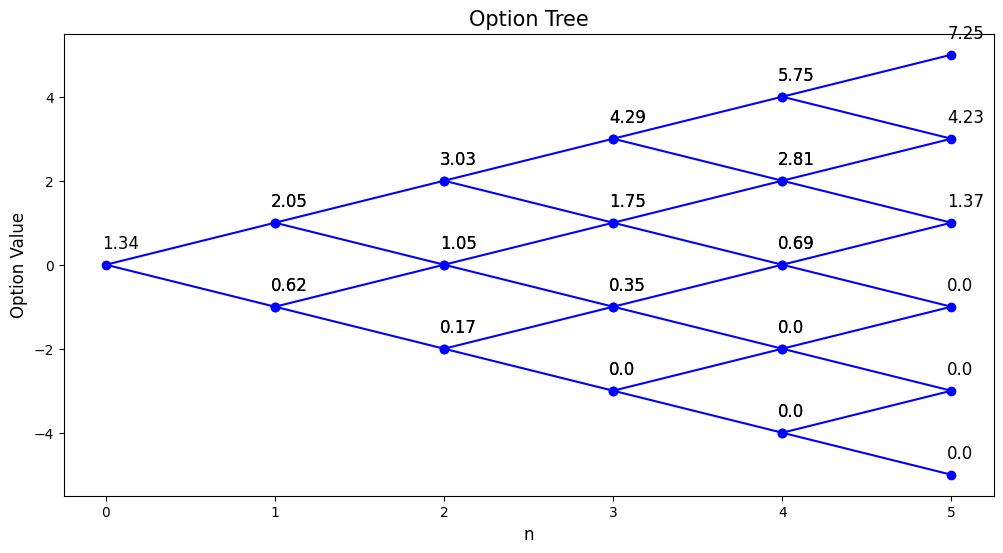

In [7]:
opt1_CRR = fo.binomial_tree_options.CRRBinomialTreeOption(S=S0,
                                                          K=K, t=T,
                                                          r=r, b=r,
                                                          sigma=vol,
                                                          n=N, type='european')

#b: taxa de custo de carregamento. Geralmente, simplesmente utilize a taxa livre de risco aqui.
print(f"Preço da opção call: {opt1_CRR.call() :.3f}")
print()

_ = opt1_CRR.plot(call=True, figsize=(12,6))

A opção para call nesse cenário será exercida quando houver ao menos 3 subidas no ativo objeto

#### PUT 

Preço da opção Put: 1.2126



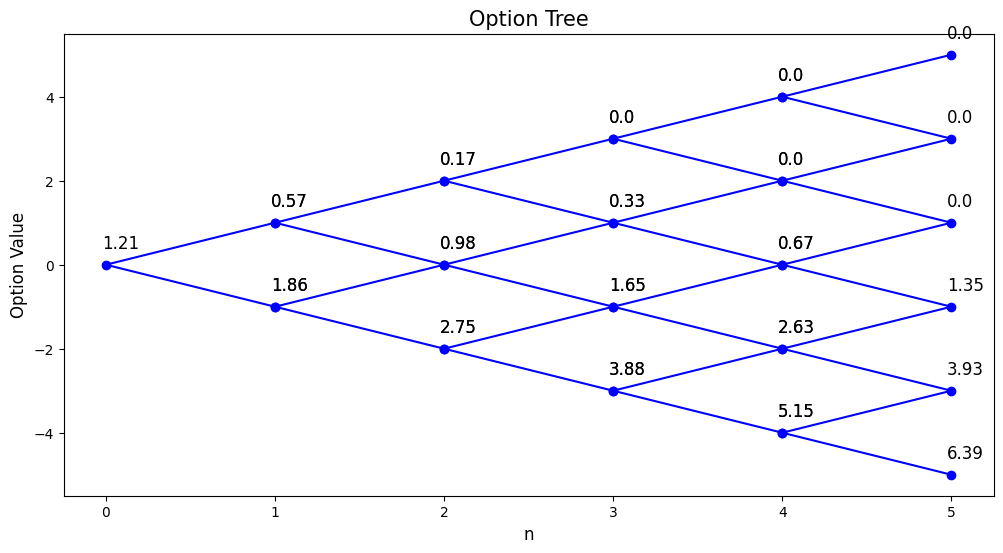

In [8]:
opt1_CRR = fo.binomial_tree_options.CRRBinomialTreeOption(S=S0,
                                                          K=K, t=T,
                                                          r=r, b=r,
                                                          sigma=vol,
                                                          n=N, type='european')
print(f"Preço da opção Put: {opt1_CRR.put() :.4f}")
print()
_ = opt1_CRR.plot(call=False, figsize=(12,6))

A put será exercida se houver ao menos 3 quedas no preço do ativo objeto

#### Q2) Considere o Exercício 1). Varie o número de passos de 5 a 20 e faça um gráfico dos valores precificados da opção em função do número de passos

In [385]:
calls = []
puts = []

opt1_BS = fo.BlackScholesOption(S = S0,
                                K = K,
                                t = T,
                                r = r,
                                b = r,
                                sigma = vol)

x_range = np.arange(5,20)
for i in x_range:
    option = fo.binomial_tree_options.CRRBinomialTreeOption(
                S=S0, K=K, t=T, r=r, b=r, sigma=vol, n=i, type='european')
    
    call_price = option.call()
    put_price = option.put()
    
    calls.append(call_price)
    puts.append(put_price)

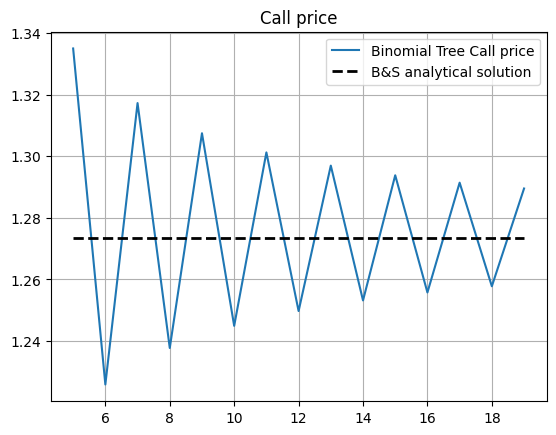

In [386]:
# Call
plt.plot(x_range, calls, label='Binomial Tree Call price')
plt.plot(x_range, [opt1_BS.call(),]*len(x_range), 'k--', lw=2, label='B&S analytical solution')
plt.title('Call price')
plt.legend()
plt.grid()

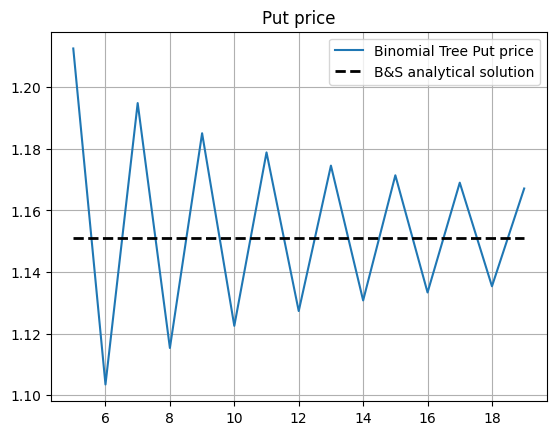

In [387]:
# Put
plt.plot(x_range, puts, label='Binomial Tree Put price')
plt.plot(x_range, [opt1_BS.put(),]*len(x_range), 'k--', lw=2, label='B&S analytical solution')
plt.title('Put price')
plt.legend()
plt.grid()
# plt.plot(np.arange(5,20), puts)

Pode-se perceber que os preços para call e put convergem para o valor analítico da equação de Black and Scholes

#### Q3)  Modifique a função difFin2.R para calcular o preço de uma opção europeia, mas considerando a seguinte equação. Compare o resultado o método de árvore binomial CCR e com a solução analítica de BlackScholes.

$$
V_{i, j-1} = a_iV_{i-1,j}+b_iV{i,j}+c_iV_{i+1,j} 
$$

em que

$$
a_i = \frac{1}{2}\sigma^2i^2\delta t -  \frac{1}{2}ri\delta t
$$

$$
b_i = 1 - r\delta t - \sigma^2i^2\delta t
$$

$$
c_i = \frac{1}{2}\sigma^2 i^2 \delta t +  \frac{1}{2}ri\delta t
$$

In [10]:
# Função para calcular o payoff de uma opção de compra
def Call(S, K):
    return np.maximum(S - K, 0)

# Função para calcular o payoff de uma opção de venda
def Put(S, K):
    return np.maximum(K - S, 0)

# Função principal que usa o método de diferenças finitas para avaliar o preço de uma opção
def finite_diff_abc(vol, r, payoff, K, T, N_S):
    # Define os parâmetros
    dS = 1.1 * K / N_S  # Variação do preço do ativo subjacente
    dt = 0.1 / (vol ** 2 * N_S ** 2 + r)  # Variação no tempo

    # Número de colunas na matriz
    N_t = np.ceil(T / dt).astype(int)

    # Criação de vetores e matrizes
    S = np.linspace(0.7 * K, 1.1 * K, N_S + 1)  # Vetor de preços do ativo
    dS = np.diff(S).mean()  # Variação média dos preços do ativo

    V = np.zeros((N_S + 1, N_t + 1))  # Matriz para armazenar os valores intermediários

    # Payoff na última coluna da matriz
    V[:, N_t] = payoff(S, K)

    i = (S / dS)[1:-1]
    for j in range(N_t, 0, -1):
        a_i = 0.5 * vol ** 2 * i ** 2 * dt - 0.5 * r * i * dt
        b_i = 1 - r * dt - vol ** 2 * i ** 2 * dt
        c_i = 0.5 * vol ** 2 * i ** 2 * dt + 0.5 * r * i * dt

        # Atualização dos valores na matriz usando diferenças finitas
        V[1:N_S, j - 1] = a_i * V[0:N_S - 1, j] + b_i * V[1:N_S, j] + c_i * V[2:N_S + 1, j]

        V[0, j - 1] = 2 * V[1, j] - V[2, j]  # Condição de contorno inferior
        V[N_S, j - 1] = 2 * V[N_S - 1, j] - V[N_S - 2, j]  # Condição de contorno superior

    return V, S

S0 = 52.27
K = 52.28
T = 10 / 252
r = 6.39 / 100
N = 5
vol = 29.2 / 100

N_S = 1000

# Chamada da função principal para calcular o preço da opção de compra
V, S = finite_diff_abc(vol, r, Call, K, T, N_S)

# Encontra o índice mais próximo do preço inicial S0
idx = np.argsort(np.abs(S - S0))[0]
V_price_diff_fin = V[idx, 0]

# Exemplo de cálculos usando o modelo de Black-Scholes e árvore binomial CRR
opt1_BS = fo.BlackScholesOption(S0, K, T, r, r, vol)
V_price_BS = opt1_BS.call()
opt1_CRR = fo.binomial_tree_options.CRRBinomialTreeOption(S0, K, T, r, r, vol, 'european', 300)
V_price_CRR = opt1_CRR.call()

# Imprime os resultados
print("B&S: ", V_price_BS)
print("Dif_fin: ", V_price_diff_fin)
print("CRR: ", V_price_CRR)

B&S:  1.2735507695959463
Dif_fin:  1.2771685251973615
CRR:  1.27276154492456


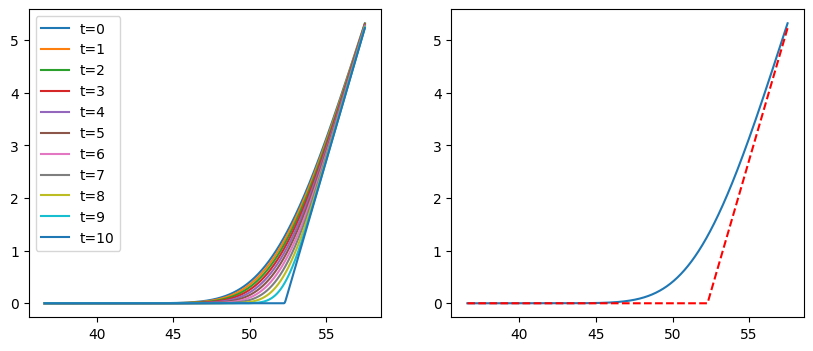

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4))

n_t = len(V[-1])
for t in range(0, n_t, n_t//10):
    ax1.plot(S, V[:, t], label = f't={t*10/n_t :.0f}')
    
ax2.plot(S, V[:,0])
ax2.plot(S, V[:,-1],'r--')
ax1.legend()
plt.show()

#### Q4) Modifique a função difFin2.R para calcular o preço de uma opção tipo Call com barreira Up and Out. Apresente os gráficos com os valores de V em função de S, para vários valores de tempo.
Assuma:

 - Preço de exercício da opção K = R\\$ 50.00;
 - Volatilidade do ativo-objeto: $\sigma$ = 0.30;
 - Taxa de retorno livre de risco: r = 0.07;
 - Tempo para o vencimento: T = 3 meses;
 - Barreira: R\\$ 80.00

In [12]:
# Função para calcular o payoff de uma opção de compra com barreira "up and out"
def up_and_out_call_payoff(S, K, barrier):
    S = np.where(S < barrier, S, 0)  # Define S como zero para valores maiores que a barreira
    return np.maximum(S - K, 0)  # Calcula o payoff da opção de compra "up and out"

# Função principal que utiliza o método de diferenças finitas para avaliar opção "up and out"
def diff_fin_up_out(vol, r, payoff, K, T, N_S, barrier):
    # Define parâmetros
    dt = 0.1 / (vol ** 2 * N_S**2 + r)  # Variação no tempo
    N_t = np.ceil(T / dt).astype(int)  # Número de passos no tempo

    # Criação de vetores e matrizes
    S = np.linspace(0.5 * K, barrier * 1.1, N_S + 1)  # Vetor de preços do ativo
    dS = np.diff(S).mean()  # Variação média dos preços do ativo

    V = np.zeros((N_S + 1, N_t + 1))  # Matriz para armazenar os valores intermediários

    # Payoff na última coluna da matriz
    V[:, N_t] = payoff(S, K, barrier)

    for n in range(N_t, 0, -1):
        Delta = (V[2:N_S+1, n] - V[0:N_S-1, n]) / (2 * dS)  # Derivada primeira
        Gamma = (V[2:N_S+1, n] - 2*V[1:N_S, n] + V[0:N_S-1, n]) / dS**2  # Derivada segunda
        Theta = -0.5 * vol**2 * S[1:N_S]**2 * Gamma - r * S[1:N_S] * Delta + r * V[1:N_S, n]  # Termo Theta
        V[1:N_S, n-1] = V[1:N_S, n] - dt * Theta  # Atualização dos valores na matriz

        # Condição de contorno inferior permanece a mesma
        V[0, n-1] = 2 * V[1, n] - V[2, n]
        # Up and out: aplica na condição de contorno superior onde S > barreira
        V[S > barrier, n-1] = 0

    return V, S

# Exemplo de parâmetros
K = 50
vol = 0.3
r = 0.07
T = 3/12
N_S = 200
barrier = 80

# Chamada da função principal para calcular o preço da opção "up and out"
V, S = diff_fin_up_out(vol, r, up_and_out_call_payoff, K, T, N_S, barrier)

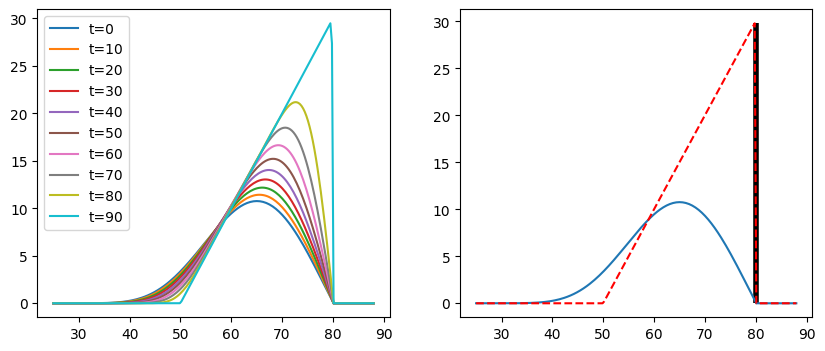

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4))

n_t = len(V[-1])
for t in range(0, n_t, 1000):
    ax1.plot(S, V[:, t], label = f't={t*90/n_t :.0f}')
    
ax2.plot(S, V[:,0])
ax2.plot(S, V[:,-1],'r--')
ax2.vlines(barrier, 0, max(V[:,-1]), color='k', ls='-', lw=4, zorder=-1)
ax1.legend()
plt.show()

#### Q5) Refaça o preenchimento da aba 19.2 e faça o preenchimento da aba 19.3 da planilha rebalanceamento_hull_alunos.xlsx. Para cada aba, obtenha

- d1, N(d1), d2 e N(d2)
- O Delta da opção
- O preço da opção
- A quantidade de ações necessárias a cada instante na carteira neutra ao risco
- A quantidade de ações a ser comprada ou vendida semanalmente (rebalanceamento)
- O custo da carteira a cada instante devido ao rebalanceamento
- O custo dos juros a cada instante
- O custo cumulativo (ações compradas + juros) ao longo do tempo
- O custo de se fazer o hedge da opção o hedge da opção.
 
Como o custo de se fazer o hedge poderia se aproximar mais do modelo Black-Scholes?

**Cálculos na planilha em anexo**

Para fazer o valor se aproximar mais do modelo de Black-Scholes, seria necessário:

- rebalanceamento mais frequente
  
- rebalanceamento com lotes menores, possivelmente unitários
  
- adicionar os custos de transação e alterar a volatilidade do modelos de acordo com 

$$
\bar \sigma = \sigma *( 1 + \sqrt{1 + \frac{2}{\pi\delta t}}\frac{k}{\sigma})
$$